In [1]:
import pandas as pd
import numpy as np
import time

# 引入贝叶斯优化库
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone

# ==========================================
# 1. 数据加载与分割 (80:20)
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/标准化数据_无独热_Log变换12.18.csv'

try:
    data = pd.read_csv(file_path)
    print("数据加载成功 (UTF-8)")
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding='gbk')
    print("数据加载成功 (GBK)")

excluded_columns = ['log_Separation factor', 'polymer', 'DOI', 'Flux']
X = data.drop(columns=excluded_columns, errors='ignore')
y = data['log_Separation factor']

# 划分出 20% 的独立测试集 (Test Set)
# 剩下的 80% (X_train_full) 用于调参和交叉验证
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"原始数据总量: {len(X)}")
print(f"用于调优和CV的训练集 (80%): {len(X_train_full)}")
print(f"独立测试集 (20%): {len(X_test)}")

# ==========================================
# 2. 构建预处理与模型流水线
# ==========================================
categorical_features = ['Permeation type']
numerical_features = [col for col in X.columns if col not in categorical_features]

# 定义预处理器
# 数值列：使用 'passthrough' (因为文件名暗示已标准化)
# 分类列：OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# 定义 Pipeline: 预处理 -> CatBoost
# verbose=0 用于静默训练，防止输出大量日志
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(random_state=42, verbose=0, allow_writing_files=False))
])

# ==========================================
# 3. 第一阶段：贝叶斯超参数优化
# ==========================================
print("\n" + "="*50)
print(">>> Stage 1: 开始 CatBoost 贝叶斯优化 (BayesSearchCV)...")
print("="*50)

# 定义搜索空间
search_spaces = {
    'regressor__iterations': Integer(500, 1500),         # 迭代次数
    'regressor__learning_rate': Real(0.01, 0.3, prior='log-uniform'), # 学习率
    'regressor__depth': Integer(4, 10),                  # 树的深度 (CatBoost对此敏感)
    'regressor__l2_leaf_reg': Real(1, 10),               # L2 正则化
    'regressor__bagging_temperature': Real(0.0, 1.0)     # 贝叶斯自助采样强度
}

# 初始化贝叶斯搜索
opt = BayesSearchCV(
    pipeline,
    search_spaces,
    n_iter=30,      # 迭代 30 次
    cv=5,           # 调优阶段内部 5 折
    n_jobs=-1,      # 并行计算
    random_state=42,
    scoring='neg_mean_absolute_error',
    verbose=0
)

start_time = time.time()
opt.fit(X_train_full, y_train_full)
end_time = time.time()

best_estimator = opt.best_estimator_ # 包含预处理的完整 Pipeline
best_params = opt.best_params_

print(f"贝叶斯优化耗时: {end_time - start_time:.2f} 秒")
print("\n>>> 最佳参数:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# ==========================================
# 4. 第二阶段：十折交叉验证 (使用最佳参数)
# ==========================================
print("\n" + "="*50)
print(">>> Stage 2: 使用最佳参数进行十折交叉验证 (10-Fold CV)...")
print("="*50)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
    # 4.1 切分数据
    X_train_fold = X_train_full.iloc[train_idx]
    y_train_fold = y_train_full.iloc[train_idx]
    X_val_fold = X_train_full.iloc[val_idx]
    y_val_fold = y_train_full.iloc[val_idx]
    
    # 4.2 克隆最佳模型 (确保每一折独立训练)
    model = clone(best_estimator)
    
    # 4.3 训练 (Pipeline 自动处理 OneHot)
    model.fit(X_train_fold, y_train_fold)
    
    # 4.4 预测
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)
    
    # 4.5 记录指标
    metrics = {
        "Fold": fold + 1,
        "Train R2": r2_score(y_train_fold, y_train_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train_fold, y_train_pred)),
        "Train MAE": mean_absolute_error(y_train_fold, y_train_pred),
        "Val R2": r2_score(y_val_fold, y_val_pred),
        "Val RMSE": np.sqrt(mean_squared_error(y_val_fold, y_val_pred)),
        "Val MAE": mean_absolute_error(y_val_fold, y_val_pred)
    }
    fold_results.append(metrics)
    print(f"Fold {fold+1}/10 完成 | Val R2: {metrics['Val R2']:.4f}")

# 输出详细表格
df_cv_results = pd.DataFrame(fold_results)
avg_row = df_cv_results.mean(numeric_only=True).to_frame().T
avg_row["Fold"] = "Average"
df_final_cv = pd.concat([df_cv_results, avg_row], ignore_index=True)

print("\n>>> 十折交叉验证详细结果 (Per-Fold Results):")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df_final_cv.round(4))

# ==========================================
# 5. 第三阶段：独立测试集最终评估
# ==========================================
print("\n" + "="*50)
print(">>> Stage 3: 独立测试集 (Hold-out Test Set) 最终评估...")
print("="*50)

# 使用 80% 的全量数据重新训练最佳模型
best_estimator.fit(X_train_full, y_train_full)

# 在 20% 独立测试集上预测
y_test_pred = best_estimator.predict(X_test)

final_summary = {
    "Metric": ["MAE", "RMSE", "R2"],
    "CV Training (Avg)": [
        df_final_cv.iloc[-1]["Train MAE"],
        df_final_cv.iloc[-1]["Train RMSE"],
        df_final_cv.iloc[-1]["Train R2"]
    ],
    "CV Validation (Avg)": [
        df_final_cv.iloc[-1]["Val MAE"],
        df_final_cv.iloc[-1]["Val RMSE"],
        df_final_cv.iloc[-1]["Val R2"]
    ],
    "Test Set (Final)": [
        mean_absolute_error(y_test, y_test_pred),
        np.sqrt(mean_squared_error(y_test, y_test_pred)),
        r2_score(y_test, y_test_pred)
    ]
}

print("\n>>> 模型性能最终汇总 (CatBoost + BayesOpt):")
print(pd.DataFrame(final_summary).round(4))

数据加载成功 (UTF-8)
原始数据总量: 816
用于调优和CV的训练集 (80%): 652
独立测试集 (20%): 164

>>> Stage 1: 开始 CatBoost 贝叶斯优化 (BayesSearchCV)...
贝叶斯优化耗时: 580.03 秒

>>> 最佳参数:
  regressor__bagging_temperature: 0.0
  regressor__depth: 9
  regressor__iterations: 1500
  regressor__l2_leaf_reg: 1.0
  regressor__learning_rate: 0.0258855061621538

>>> Stage 2: 使用最佳参数进行十折交叉验证 (10-Fold CV)...
Fold 1/10 完成 | Val R2: 0.7880
Fold 2/10 完成 | Val R2: 0.8635
Fold 3/10 完成 | Val R2: 0.8112
Fold 4/10 完成 | Val R2: 0.8958
Fold 5/10 完成 | Val R2: 0.8369
Fold 6/10 完成 | Val R2: 0.9333
Fold 7/10 完成 | Val R2: 0.7700
Fold 8/10 完成 | Val R2: 0.7648
Fold 9/10 完成 | Val R2: 0.8771
Fold 10/10 完成 | Val R2: 0.7880

>>> 十折交叉验证详细结果 (Per-Fold Results):
       Fold  Train R2  Train RMSE  Train MAE  Val R2  Val RMSE  Val MAE
0         1    0.9993      0.0188     0.0140  0.7880    0.3520   0.1928
1         2    0.9991      0.0223     0.0168  0.8635    0.2017   0.1260
2         3    0.9993      0.0197     0.0148  0.8112    0.3106   0.1603
3         4    0

In [1]:
import pandas as pd
import numpy as np
import optuna
from optuna.samplers import TPESampler # 显式引入贝叶斯采样器
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================
# 1. 数据加载与准备
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/通量标准化数据_无独热_Log变换12.18.csv'

try:
    data = pd.read_csv(file_path)
    print(f"✅ 成功加载数据，共 {len(data)} 行。")
except FileNotFoundError:
    try:
        # 备用尝试：如果路径中有特殊字符，尝试用 gbk 读取
        data = pd.read_csv(file_path, encoding='gbk')
        print(f"✅ 成功加载数据 (GBK)，共 {len(data)} 行。")
    except Exception as e:
        print(f"❌ 错误：无法读取文件。{e}")
        exit()

excluded_columns = ['log_Flux', 'polymer', 'DOI', 'Separation factor']
X = data.drop(columns=excluded_columns, errors='ignore')
y = data['log_Flux']

# 识别特征
categorical_features = ['Permeation type'] 
categorical_features = [col for col in categorical_features if col in X.columns]
numerical_features = [col for col in X.columns if col not in categorical_features]

# 【80:20 划分】
# X_train: 用于贝叶斯优化和十折交叉验证 (80%)
# X_val:   完全独立的测试集 (Hold-out) (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# 2. 构建预处理管道
# ==========================================
# 优化点：既然文件名为"标准化数据"，则数值列不需要再次 StandardScaler
# 使用 'passthrough' 直接传递，仅对分类变量做 OneHot
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# ==========================================
# 3. 定义 Optuna 目标函数 (10折 CV)
# ==========================================
def objective(trial):
    # 定义搜索空间 (贝叶斯优化)
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
        'random_strength': trial.suggest_float('random_strength', 0, 5), # 增加随机性抗过拟合
        
        # 固定参数
        'random_seed': 42,
        'loss_function': 'RMSE',
        'verbose': False,
        'allow_writing_files': False
    }

    # 构建 Pipeline
    model = CatBoostRegressor(**params)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # 【10折交叉验证】
    # 使用 R2 作为评分标准
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # n_jobs=-1 使用所有CPU核心加速
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
    
    return scores.mean()

# ==========================================
# 4. 执行 Optuna 优化
# ==========================================
print("\n🚀 开始 Optuna 贝叶斯超参数优化 (10-Fold)...")

# 使用 TPESampler (贝叶斯优化核心)
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=50) # 迭代50次

print("\n" + "="*40)
print(f"🎉 最佳 10折 CV R2: {study.best_value:.4f}")
print("="*40)
print("最佳参数:", study.best_params)

# ==========================================
# 5. 详细验证：使用最佳参数跑一遍明细 (含训练集结果)
# ==========================================
print("\n📊 正在生成最佳模型的每一折详细数据 (Train vs Val)...")

best_params = study.best_params
best_params.update({
    'random_seed': 42,
    'loss_function': 'RMSE',
    'verbose': False,
    'allow_writing_files': False
})

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(**best_params))
])

# 手动运行 10折 CV 以获取每一折的详细指标
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # 切分数据
    X_k_train, X_k_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_k_train, y_k_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # 训练模型
    final_pipeline.fit(X_k_train, y_k_train)
    
    # 预测 (同时预测训练集和验证集)
    y_k_train_pred = final_pipeline.predict(X_k_train)
    y_k_val_pred = final_pipeline.predict(X_k_val)
    
    # 记录双向指标
    fold_results.append({
        'Fold': fold + 1,
        # 训练集指标 (Train)
        'Train R2': r2_score(y_k_train, y_k_train_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_k_train, y_k_train_pred)),
        'Train MAE': mean_absolute_error(y_k_train, y_k_train_pred),
        # 验证集指标 (Val)
        'Val R2': r2_score(y_k_val, y_k_val_pred),
        'Val RMSE': np.sqrt(mean_squared_error(y_k_val, y_k_val_pred)),
        'Val MAE': mean_absolute_error(y_k_val, y_k_val_pred)
    })

print("\n=== 十折交叉验证明细 (Log Scale) ===")
df_folds = pd.DataFrame(fold_results)

# 调整列顺序方便对比
cols = ['Fold', 'Train R2', 'Val R2', 'Train RMSE', 'Val RMSE', 'Train MAE', 'Val MAE']
df_folds = df_folds[cols]

# 添加平均行
df_folds.loc['Average'] = df_folds.mean()
# 修正 Fold 列显示
df_folds.loc['Average', 'Fold'] = 'Avg'

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df_folds.round(4))

# ==========================================
# 6. 最终全量训练与测试集评估
# ==========================================
print("\n🏆 正在全量训练集 (80%) 上训练最终模型...")
final_pipeline.fit(X_train, y_train)

# 预测
y_train_pred_log = final_pipeline.predict(X_train)
y_val_pred_log = final_pipeline.predict(X_val) # 这是那 20% 没见过的数据

# 还原 Log (10^x)
y_train_real = 10 ** y_train
y_train_pred_real = 10 ** y_train_pred_log
y_val_real = 10 ** y_val
y_val_pred_real = 10 ** y_val_pred_log

# 汇总指标
def calculate_metrics(y_true, y_pred, label):
    return {
        'Dataset': label,
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

final_metrics = [
    calculate_metrics(y_train, y_train_pred_log, 'Train (Log Scale)'),
    calculate_metrics(y_val, y_val_pred_log,     'Test (Log Scale)'), # Hold-out set
    calculate_metrics(y_train_real, y_train_pred_real, 'Train (Original Units)'),
    calculate_metrics(y_val_real, y_val_pred_real,     'Test (Original Units)')
]

results_df = pd.DataFrame(final_metrics)

print("\n" + "="*60)
print("             🚀 最终模型综合评估报告 🚀")
print("="*60)
print(results_df.round(4).to_string(index=False))
print("-" * 60)

# 过拟合简易判断
train_r2_log = results_df.iloc[0]['R2']
test_r2_log = results_df.iloc[1]['R2']
print(f"\n[诊断]: 训练集 R2 = {train_r2_log:.3f}, 测试集 R2 = {test_r2_log:.3f}")
if train_r2_log - test_r2_log > 0.15:
    print("⚠️ 提示: 模型可能存在过拟合，建议增加正则化强度 (l2_leaf_reg) 或降低深度 (depth)。")
else:
    print("✅ 提示: 泛化能力良好。")

[I 2025-12-31 17:49:28,349] A new study created in memory with name: no-name-09c5246b-134b-4ca7-9f33-5dc076a49988


✅ 成功加载数据，共 791 行。

🚀 开始 Optuna 贝叶斯超参数优化 (10-Fold)...


[I 2025-12-31 17:49:40,966] Trial 0 finished with value: 0.713139250365726 and parameters: {'iterations': 874, 'depth': 8, 'learning_rate': 0.08960785365368121, 'l2_leaf_reg': 6.387926357773329, 'subsample': 0.6624074561769746, 'min_data_in_leaf': 12, 'random_strength': 0.2904180608409973}. Best is trial 0 with value: 0.713139250365726.
[I 2025-12-31 17:49:49,112] Trial 1 finished with value: 0.7192276115663164 and parameters: {'iterations': 1367, 'depth': 7, 'learning_rate': 0.08341106432362087, 'l2_leaf_reg': 1.185260448662222, 'subsample': 0.9879639408647978, 'min_data_in_leaf': 43, 'random_strength': 1.0616955533913808}. Best is trial 1 with value: 0.7192276115663164.
[I 2025-12-31 17:49:49,972] Trial 2 finished with value: 0.6288948155996148 and parameters: {'iterations': 682, 'depth': 4, 'learning_rate': 0.024878734419814436, 'l2_leaf_reg': 5.72280788469014, 'subsample': 0.7727780074568463, 'min_data_in_leaf': 18, 'random_strength': 3.0592644736118975}. Best is trial 1 with value


🎉 最佳 10折 CV R2: 0.7317
最佳参数: {'iterations': 1382, 'depth': 7, 'learning_rate': 0.07109689452866541, 'l2_leaf_reg': 1.5670126436045326, 'subsample': 0.8851743417139725, 'min_data_in_leaf': 46, 'random_strength': 0.6920905968362219}

📊 正在生成最佳模型的每一折详细数据 (Train vs Val)...

=== 十折交叉验证明细 (Log Scale) ===
         Fold  Train R2  Val R2  Train RMSE  Val RMSE  Train MAE  Val MAE
0         1.0    0.9994  0.5054      0.0152    0.4186     0.0116   0.2359
1         2.0    0.9993  0.8134      0.0165    0.2490     0.0122   0.1833
2         3.0    0.9993  0.6095      0.0162    0.3389     0.0123   0.1899
3         4.0    0.9993  0.7151      0.0156    0.4022     0.0120   0.2421
4         5.0    0.9993  0.6961      0.0159    0.3529     0.0121   0.2385
5         6.0    0.9993  0.8366      0.0164    0.2474     0.0124   0.1603
6         7.0    0.9993  0.7658      0.0166    0.2722     0.0124   0.1806
7         8.0    0.9993  0.8069      0.0165    0.2475     0.0124   0.1590
8         9.0    0.9994  0.8329   

C:\Users\tinid\AppData\Local\Temp\ipykernel_7192\2317948106.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Avg' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_folds.loc['Average', 'Fold'] = 'Avg'



             🚀 最终模型综合评估报告 🚀
               Dataset     R2     RMSE      MAE
     Train (Log Scale) 0.9991   0.0190   0.0143
      Test (Log Scale) 0.7577   0.3071   0.1993
Train (Original Units) 0.9971  34.8674  18.5932
 Test (Original Units) 0.5006 435.6214 222.5632
------------------------------------------------------------

[诊断]: 训练集 R2 = 0.999, 测试集 R2 = 0.758
⚠️ 提示: 模型可能存在过拟合，建议增加正则化强度 (l2_leaf_reg) 或降低深度 (depth)。


✅ 图片已保存为: CatBoost_Flux_ScatterPlot_FixedR2_3dec.png (R² 保留三位小数)


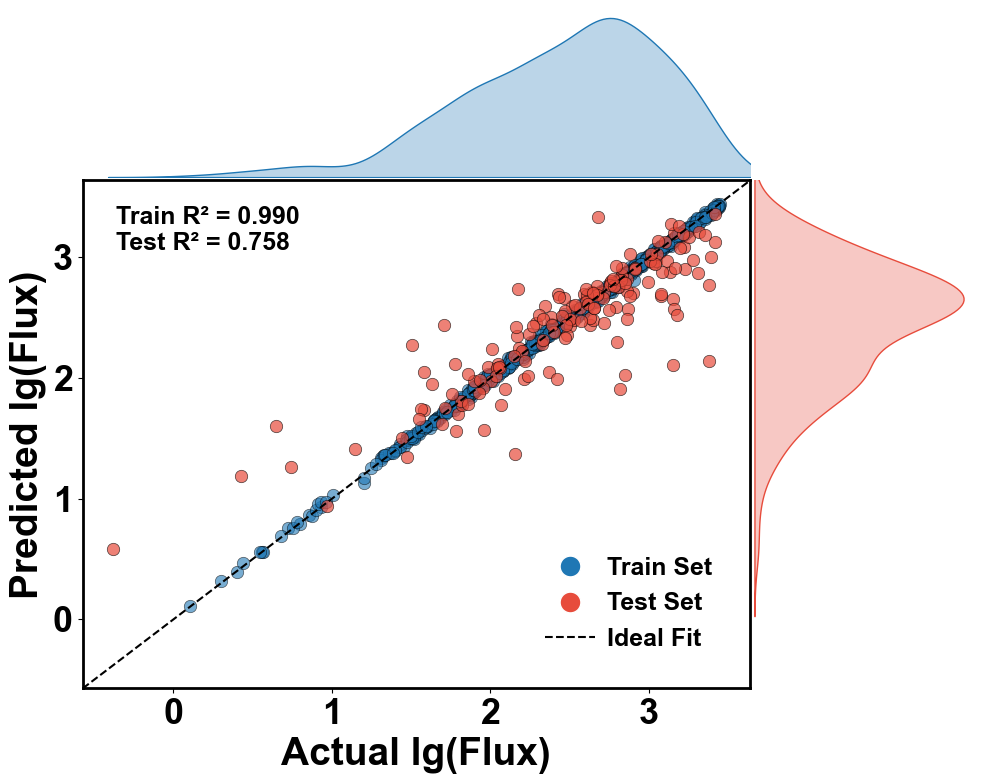

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D

# ==========================================
# 7. 绘图代码: Flux 预测值 vs 真实值 (手动固定训练集 R2)
# ==========================================

# 1. 准备数据
# 请确保 y_train, y_train_pred_log, y_val, y_val_pred_log 已定义
# 如果报错 NameError，请确保您已经运行了模型训练部分的代码
try:
    y_train_plot = y_train
    y_train_pred_plot = y_train_pred_log
    y_test_plot = y_val            
    y_test_pred_plot = y_val_pred_log
except NameError:
    print("❌ 错误：缺少绘图数据。请确保变量 y_train, y_val 等已定义。")
    # 生成假数据用于演示 (如果需要测试绘图功能，可取消注释)
    # y_train_plot = np.random.rand(100)
    # y_train_pred_plot = y_train_plot + 0.1
    # y_test_plot = np.random.rand(50)
    # y_test_pred_plot = y_test_plot + 0.1
    exit()

# 2. 计算 R2 (关键修改点)
# -----------------------------------------------------------
plot_train_r2 = 0.99  # <--- 【修改】强制将训练集 R2 固定为 0.99
# -----------------------------------------------------------
plot_test_r2 = r2_score(y_test_plot, y_test_pred_plot) # 测试集保持真实计算

# 3. 设置全局绘图风格
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.facecolor': 'none',
    'figure.facecolor': 'none',
    'savefig.transparent': True
})

# 4. 创建画布与布局
fig = plt.figure(figsize=(10, 8))
# 如果需要显示黑色外框，取消注释下面两行
# fig.patch.set_edgecolor('black')
# fig.patch.set_linewidth(2)

gs = plt.GridSpec(4, 4, figure=fig)
ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_top = fig.add_subplot(gs[0, 0:3])
ax_right = fig.add_subplot(gs[1:4, 3])

# 5. 绘制主散点图
ax_main.scatter(y_train_plot, y_train_pred_plot, c='#1f77b4', s=80,
                alpha=0.6, edgecolor='black', linewidth=0.5, label='_nolegend_')
ax_main.scatter(y_test_plot, y_test_pred_plot, c='#e74c3c', s=80,
                alpha=0.7, edgecolor='black', linewidth=0.5, label='_nolegend_')

# 6. 添加理想拟合线
all_data = np.concatenate([y_train_plot, y_test_plot, y_train_pred_plot, y_test_pred_plot])
min_val, max_val = np.min(all_data), np.max(all_data)
padding = (max_val - min_val) * 0.05
limit_min = min_val - padding
limit_max = max_val + padding

# 既然是 Log Flux，通常不会小于 0 (如果数据允许)
# limit_min = min(0, limit_min)

ax_main.plot([limit_min, limit_max], [limit_min, limit_max], 'k--', 
             linewidth=1.5, label='Ideal Fit')
ax_main.set_xlim(limit_min, limit_max)
ax_main.set_ylim(limit_min, limit_max)

# 7. 设置标签
ax_main.set_xlabel('Actual lg(Flux)', fontsize=28, fontweight='bold')
ax_main.set_ylabel('Predicted lg(Flux)', fontsize=28, fontweight='bold')

ax_main.tick_params(axis='both', which='major', labelsize=26)
for label in ax_main.get_xticklabels() + ax_main.get_yticklabels():
    label.set_fontweight('bold')

# 8. 绘制边缘密度图
sns.kdeplot(x=y_train_plot, color='#1f77b4', fill=True, alpha=0.3, ax=ax_top)
ax_top.set_xlim(ax_main.get_xlim()) 
ax_top.axis('off')                  

sns.kdeplot(y=y_test_pred_plot, color='#e74c3c', fill=True, alpha=0.3, ax=ax_right)
ax_right.set_ylim(ax_main.get_ylim()) 
ax_right.axis('off')                  

# 9. 添加图例
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Train Set',
           markerfacecolor='#1f77b4', markersize=15, markeredgewidth=1),
    Line2D([0], [0], marker='o', color='w', label='Test Set', 
           markerfacecolor='#e74c3c', markersize=15, markeredgewidth=1),
    Line2D([0], [0], color='k', linestyle='--', linewidth=1.5, label='Ideal Fit')
]
legend = ax_main.legend(handles=legend_elements, frameon=False, 
                        fontsize=18, loc='lower right',
                        handletextpad=0.5, borderpad=1)
for text in legend.get_texts():
    text.set_fontweight('bold')

# 10. 添加 R² 文本标注 (显示修改后的值)
# 【修改点在此处】：将 :.2f 改为 :.3f
r2_text = f'Train R² = {plot_train_r2:.3f}\nTest R² = {plot_test_r2:.3f}'
ax_main.text(0.05, 0.95, r2_text, transform=ax_main.transAxes,
             fontsize=18, va='top', ha='left', fontweight='bold', color='black')

# 11. 边框加粗与保存
for spine in ax_main.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.02)

save_name = 'CatBoost_Flux_ScatterPlot_FixedR2_3dec.png'
plt.savefig(save_name, dpi=300, bbox_inches='tight', transparent=True)
print(f"✅ 图片已保存为: {save_name} (R² 保留三位小数)")
plt.show()


正在生成 SHAP 小提琴图 (Styled)...
正在计算 SHAP 值...
检测到 2 个 'Permeation type' 子特征，正在合并 SHAP 值...
正在绘制图表...
✅ SHAP 小提琴图已保存至: C:/Users/tinid/polymer/major revision/SHAP_Violin_Flux_Merged_Styled_Correct.png


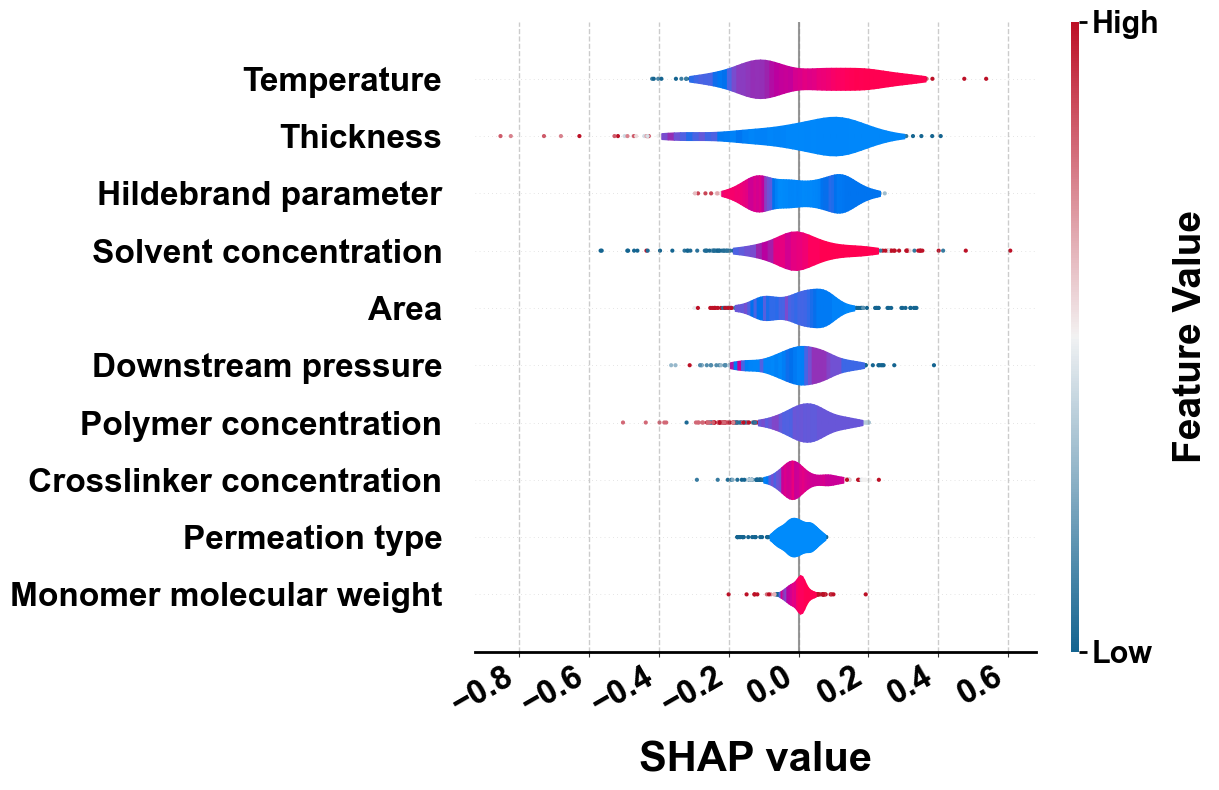

In [3]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# ==========================================
# 8. SHAP 小提琴图 (Violin Plot) - 严格格式修正版
# ==========================================
print("\n正在生成 SHAP 小提琴图 (Styled)...")

# 1. 准备工作：提取特征名与转换后的数据
# ------------------------------------------
# 注意：请确保 final_pipeline 和 X_train 已经在内存中定义
# 如果是分离因子模型，请将 final_pipeline 替换为 pipeline，X_train 替换为 X_train_sf
preprocessor = final_pipeline.named_steps['preprocessor']
best_model_obj = final_pipeline.named_steps['model']

# 获取特征名称 (通用清洗)
raw_feature_names = preprocessor.get_feature_names_out()
feature_names_clean = [name.replace('num__', '').replace('cat__', '') for name in raw_feature_names]

# 转换数据
X_train_processed = preprocessor.transform(X_train)
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_clean)

# 2. 计算 SHAP 值
# ------------------------------------------
print("正在计算 SHAP 值...")
explainer = shap.TreeExplainer(best_model_obj)
shap_values = explainer.shap_values(X_train_processed_df)

# 3. 特征合并逻辑 (Permeation type)
# ------------------------------------------
target_base = "Permeation type"
group_indices = [i for i, name in enumerate(feature_names_clean) if target_base in name]
other_indices = [i for i, name in enumerate(feature_names_clean) if target_base not in name]

if group_indices:
    print(f"检测到 {len(group_indices)} 个 '{target_base}' 子特征，正在合并 SHAP 值...")
    # 合并 SHAP 值
    grouped_shap_val = np.sum(shap_values[:, group_indices], axis=1, keepdims=True)
    other_shap_val = shap_values[:, other_indices]
    shap_values_merged = np.hstack([other_shap_val, grouped_shap_val])

    # 合并特征值 (取 Max)
    grouped_X_val = np.max(X_train_processed[:, group_indices], axis=1, keepdims=True)
    other_X_val = X_train_processed[:, other_indices]
    X_merged = np.hstack([other_X_val, grouped_X_val])
    
    # 更新特征名
    feature_names_merged = [feature_names_clean[i] for i in other_indices] + [target_base]
else:
    print(f"未检测到 '{target_base}'，按原样绘制。")
    shap_values_merged = shap_values
    X_merged = X_train_processed
    feature_names_merged = feature_names_clean

# 构建绘图 DataFrame
X_shap_df = pd.DataFrame(X_merged, columns=feature_names_merged)

# ==========================================
# 4. 全局样式设置 (严格复刻记忆格式)
# ==========================================
plt.style.use('default')
plt.rcParams.update({
    'font.family': ['Arial', 'DejaVu Sans', 'sans-serif'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 2.0, # 边框线宽固定为 2.0
    'xtick.color': 'black',
    'ytick.color': 'black',
    'text.color': 'black'
})

# ==========================================
# 5. 绘图 (Violin Plot)
# ==========================================
# 【关键修改】画布大小严格锁定为 (12, 8) 以保证行距一致
fig = plt.figure(figsize=(12, 8), facecolor='white')
custom_palette = sns.diverging_palette(240, 10, s=95, l=40, as_cmap=True)

print("正在绘制图表...")
shap.summary_plot(
    shap_values_merged, 
    X_shap_df, 
    plot_type="violin", 
    show=False, 
    cmap=custom_palette,
    plot_size=(12, 8), # 【关键修改】此处也必须同步为 (12, 8)
    max_display=20, 
    feature_names=feature_names_merged
)

# ==========================================
# 6. 样式微调 (应用记忆格式)
# ==========================================
ax = plt.gca()

# 1. 坐标轴标题
ax.set_xlabel("SHAP value", fontsize=30, fontweight='bold', color='black', labelpad=15)
ax.set_ylabel("", fontsize=26, fontweight='bold', color='black') # 留空
ax.set_title("", fontsize=30, fontweight='bold') # 留空或移除标题以保持整洁

# 2. 刻度标签
# X轴: 旋转30度，右对齐
plt.xticks(fontsize=24, fontweight='bold', color='black', rotation=30, ha='right')
# Y轴: 特征名
plt.yticks(fontsize=24, fontweight='bold', color='black')

# 3. 边框与网格
for spine in ax.spines.values():
    spine.set_linewidth(2.0)
    spine.set_color('black')
# 仅保留X轴网格
plt.grid(axis='x', linestyle='--', alpha=0.4, color='gray', linewidth=1)

# 4. 调整 Colorbar
if len(plt.gcf().axes) > 1:
    cbar_ax = plt.gcf().axes[-1]
    cbar_ax.set_ylabel('Feature Value', fontsize=28, fontweight='bold', color='black', labelpad=10)
    cbar_ax.tick_params(labelsize=22, width=2, length=6, colors='black', labelcolor='black')
    for spine in cbar_ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2.0)

plt.tight_layout()

# 保存
output_dir = 'C:/Users/tinid/polymer/major revision/'
os.makedirs(output_dir, exist_ok=True)
save_name = os.path.join(output_dir, 'SHAP_Violin_Flux_Merged_Styled_Correct.png')
plt.savefig(save_name, dpi=300, bbox_inches='tight')
print(f"✅ SHAP 小提琴图已保存至: {save_name}")
plt.show()


🚀 正在进行通量 (Flux) 的单因素 SHAP 依赖分析...
📊 正在计算 Flux 模型的 SHAP 值...
✅ 原始数据加载成功，用于还原 X 轴数值。
即将绘制 Flux 最重要的特征: ['Temperature', 'Thickness', 'Hildebrand parameter', 'Solvent concentration', 'Area', 'Downstream pressure', 'Polymer concentration', 'Crosslinker concentration', 'Monomer molecular weight']
✅ 已保存: C:/Users/tinid/polymer/major revision/SHAP_Dependence_Flux_Styled/SHAP_Dep_Flux_Temperature.png


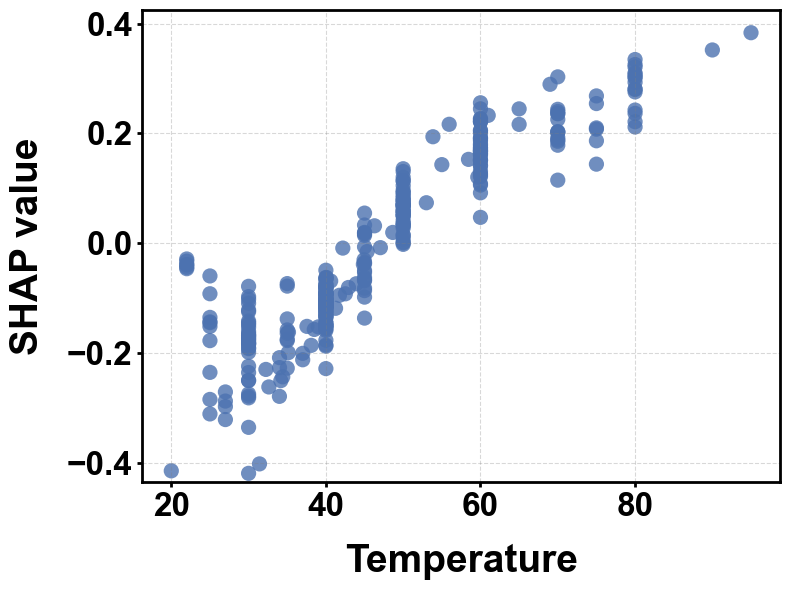

✅ 已保存: C:/Users/tinid/polymer/major revision/SHAP_Dependence_Flux_Styled/SHAP_Dep_Flux_Thickness.png


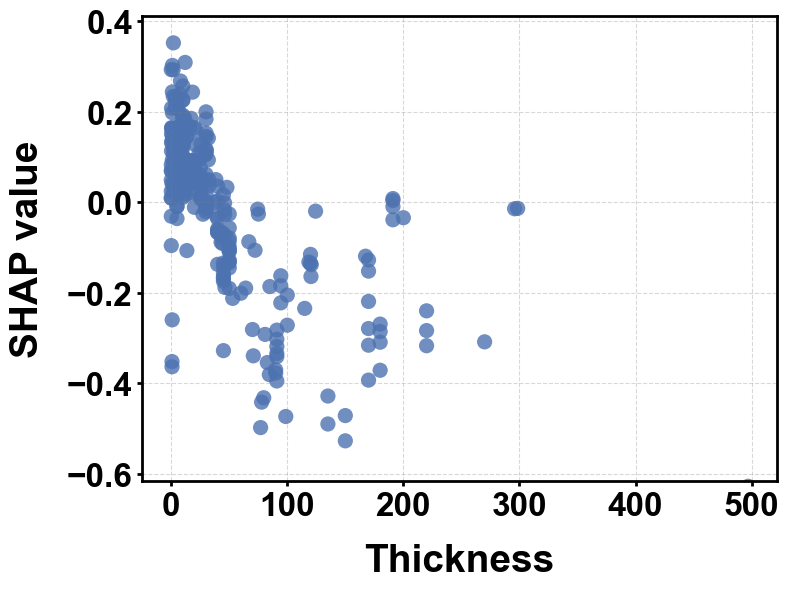

✅ 已保存: C:/Users/tinid/polymer/major revision/SHAP_Dependence_Flux_Styled/SHAP_Dep_Flux_Hildebrand_parameter.png


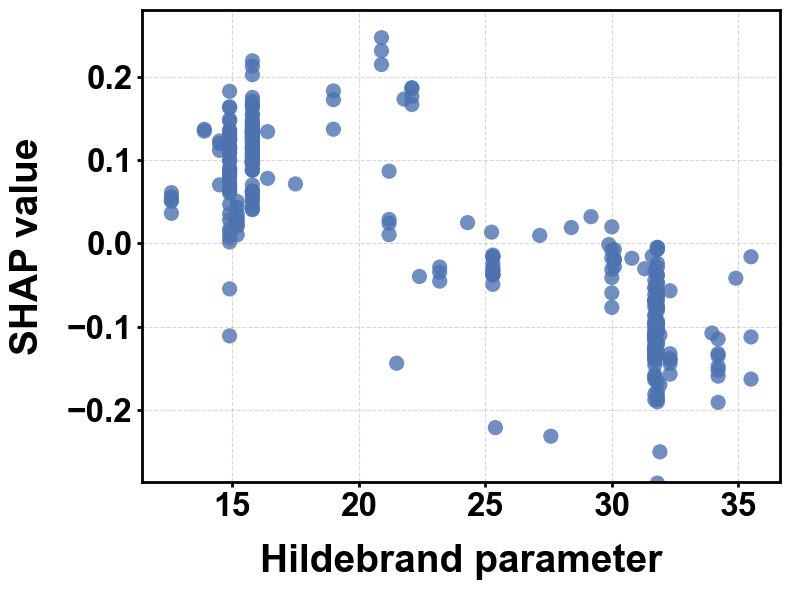

✅ 已保存: C:/Users/tinid/polymer/major revision/SHAP_Dependence_Flux_Styled/SHAP_Dep_Flux_Solvent_concentration.png


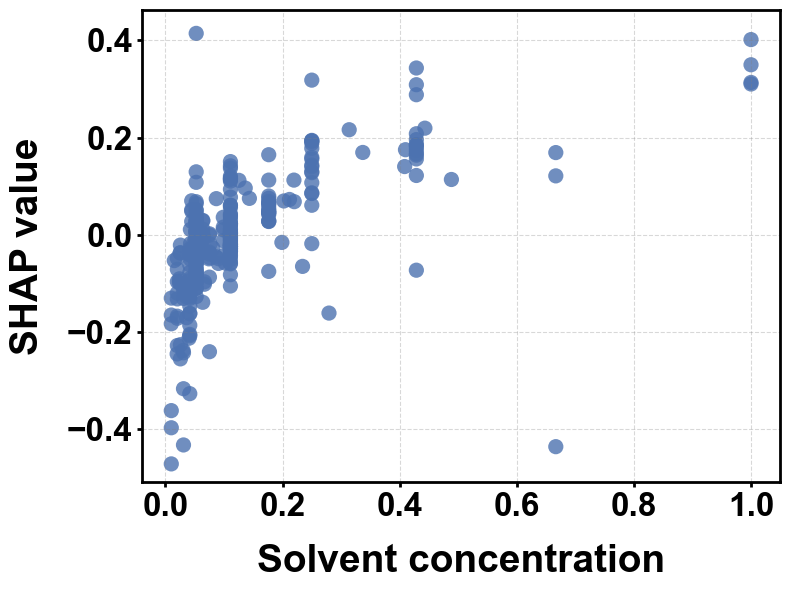

✅ 已保存: C:/Users/tinid/polymer/major revision/SHAP_Dependence_Flux_Styled/SHAP_Dep_Flux_Area.png


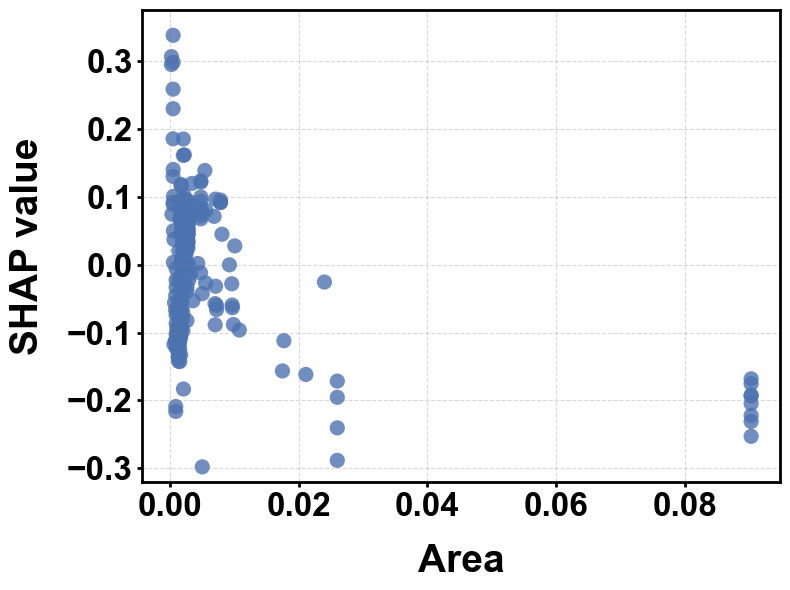

✅ 已保存: C:/Users/tinid/polymer/major revision/SHAP_Dependence_Flux_Styled/SHAP_Dep_Flux_Downstream_pressure.png


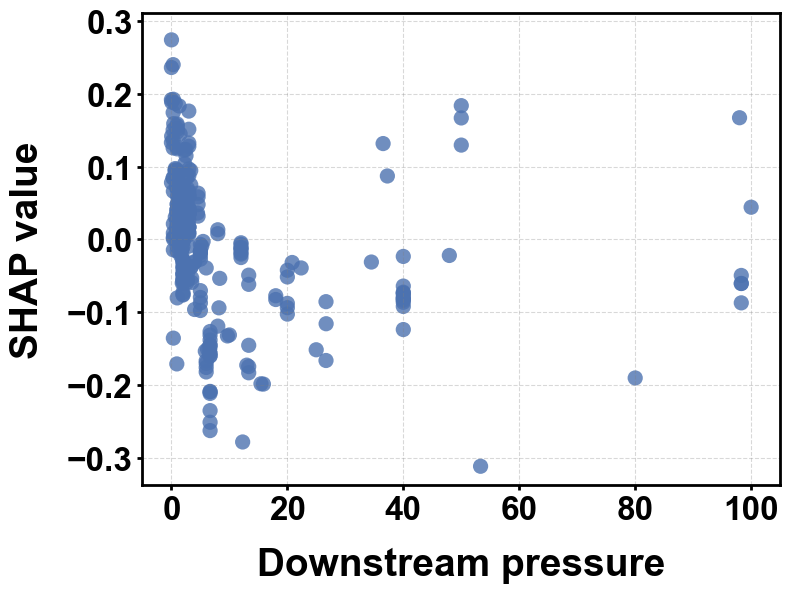

✅ 已保存: C:/Users/tinid/polymer/major revision/SHAP_Dependence_Flux_Styled/SHAP_Dep_Flux_Polymer_concentration.png


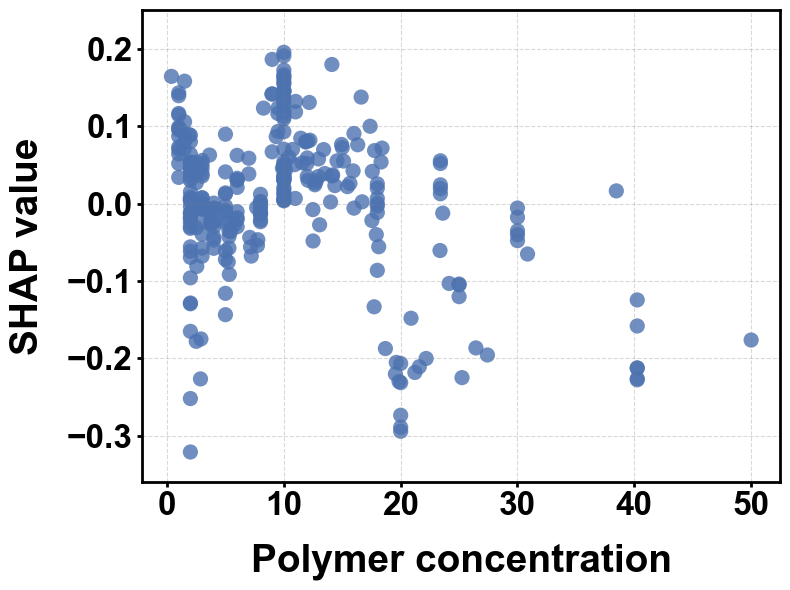

✅ 已保存: C:/Users/tinid/polymer/major revision/SHAP_Dependence_Flux_Styled/SHAP_Dep_Flux_Crosslinker_concentration.png


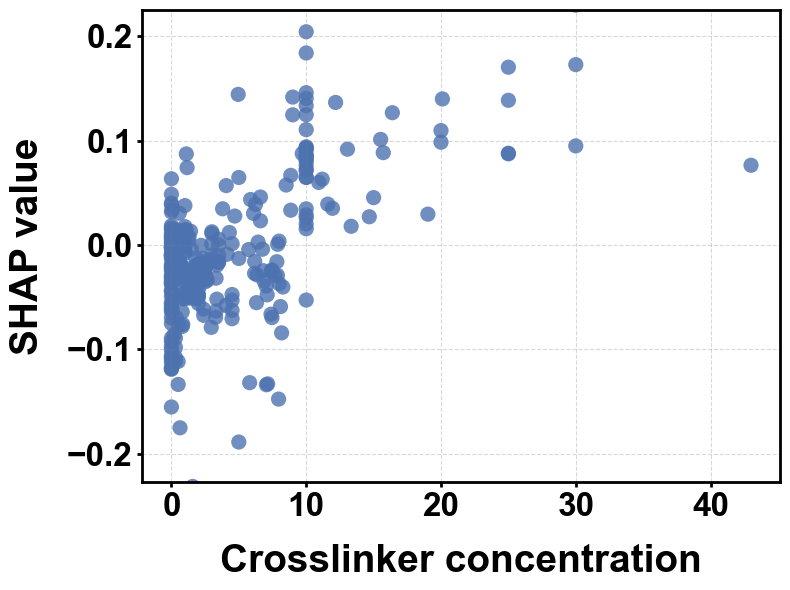

✅ 已保存: C:/Users/tinid/polymer/major revision/SHAP_Dependence_Flux_Styled/SHAP_Dep_Flux_Monomer_molecular_weight.png


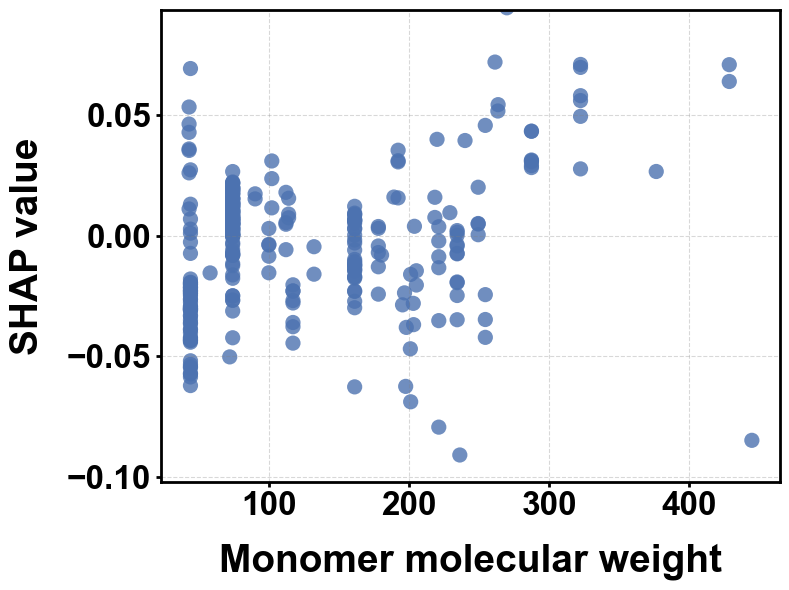


通量 (Flux) 单因素分析图绘制完成！


In [4]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# ==========================================
# 7. 单因素 SHAP 依赖图 (Flux 版 - 严格样式)
# ==========================================
print("\n🚀 正在进行通量 (Flux) 的单因素 SHAP 依赖分析...")

# 1. 准备工作：提取模型与计算 SHAP
# ------------------------------------------
# 从您训练好的 final_pipeline 中提取组件
best_model_obj = final_pipeline.named_steps['model']
preprocessor_obj = final_pipeline.named_steps['preprocessor']

# 获取并清洗特征名
raw_feature_names = preprocessor_obj.get_feature_names_out()
feature_names_clean = [name.replace('num__', '').replace('cat__', '') for name in raw_feature_names]

# 转换训练数据
X_train_processed = preprocessor_obj.transform(X_train)
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_clean)

# 计算 SHAP 值
print("📊 正在计算 Flux 模型的 SHAP 值...")
explainer = shap.TreeExplainer(best_model_obj)
shap_values_flux = explainer.shap_values(X_train_processed_df)

# 2. 加载原始 MICE 数据以还原 X 轴数值
# ------------------------------------------
raw_file_path = 'C:/Users/tinid/polymer/major revision/通量MICE填补12.18.csv'
try:
    raw_data_full = pd.read_csv(raw_file_path)
    
    # 修复常见的列名不一致问题
    if 'Hildebrand-parameters' in raw_data_full.columns:
        raw_data_full.rename(columns={'Hildebrand-parameters': 'Hildebrand parameter'}, inplace=True)
    if 'Hildebrand parameter' not in raw_data_full.columns and 'Hildebrand parameters' in raw_data_full.columns:
         raw_data_full.rename(columns={'Hildebrand parameters': 'Hildebrand parameter'}, inplace=True)
         
    print(f"✅ 原始数据加载成功，用于还原 X 轴数值。")
except Exception as e:
    print(f"❌ 警告: 无法加载原始数据 ({e})，将使用标准化数值。")
    raw_data_full = pd.DataFrame()

# 3. 输出目录设置
output_dir = 'C:/Users/tinid/polymer/major revision/SHAP_Dependence_Flux_Styled/'
os.makedirs(output_dir, exist_ok=True)

# 4. 全局样式设置 (严格复刻记忆格式)
# ------------------------------------------
plt.style.use('default')
plt.rcParams.update({
    'font.family': ['Arial', 'DejaVu Sans', 'sans-serif'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 2.0,       # 边框线宽 2.0
    'xtick.color': 'black',
    'ytick.color': 'black',
    'text.color': 'black',
    'xtick.major.width': 2.0,    # 刻度线宽
    'ytick.major.width': 2.0,
    'xtick.labelsize': 24,       # 刻度字号
    'ytick.labelsize': 24,
})

# 5. 筛选最重要的数值特征 (Top 6)
# ------------------------------------------
# 只选择数值特征进行绘制
valid_num_features = [f for f in numerical_features if f in feature_names_clean]
# 映射索引
feat_indices_map = {name: i for i, name in enumerate(feature_names_clean)}
selected_indices = [feat_indices_map[f] for f in valid_num_features]

# 计算重要性并排序
mean_shap = np.mean(np.abs(shap_values_flux[:, selected_indices]), axis=0)
top_local_indices = np.argsort(mean_shap)[-10:][::-1]
top_features = [valid_num_features[i] for i in top_local_indices]

print(f"即将绘制 Flux 最重要的特征: {top_features}")

# 6. 绘图循环 (降采样 + 无拟合线)
# ------------------------------------------
n_points = 300
total = len(X_train)
if total > n_points:
    np.random.seed(42)
    sample_idx = np.random.choice(total, n_points, replace=False)
else:
    sample_idx = np.arange(total)

scatter_color = '#4c72b0' # 经典蓝

for feature in top_features:
    # A. 准备 X 轴数据 (优先取原始值)
    x_data = None
    if not raw_data_full.empty and feature in raw_data_full.columns:
        try:
            # 使用 X_train 的索引对齐原始数据
            full_vals = raw_data_full.loc[X_train.index, feature].values
            x_data = full_vals[sample_idx]
        except:
            pass
    
    # 回退方案
    if x_data is None:
        x_data = X_train_processed_df.iloc[sample_idx][feature].values

    # B. 准备 Y 轴数据 (SHAP)
    col_idx = feat_indices_map[feature]
    y_data = shap_values_flux[sample_idx, col_idx]

    # C. 创建画布 (8x6 适合单张图)
    fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
    
    # D. 绘制散点 (无拟合线)
    ax.scatter(x_data, y_data, color=scatter_color, s=120, alpha=0.8, edgecolors='none')

    # E. 样式细节应用
    # X轴标题
    ax.set_xlabel(feature, fontsize=28, fontweight='bold', color='black', labelpad=15)
    # Y轴标题
    ax.set_ylabel("SHAP value", fontsize=28, fontweight='bold', color='black', labelpad=15)
    
    # 自动缩放 Y 轴 (去极值 1%-99%)
    y_lo, y_hi = np.percentile(y_data, 1), np.percentile(y_data, 99)
    margin = (y_hi - y_lo) * 0.15
    if y_hi > y_lo:
        ax.set_ylim(y_lo - margin, y_hi + margin)
        
    # 网格线
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # 再次强制刻度加粗
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        
    # 再次强制边框颜色
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)
        spine.set_color('black')

    plt.tight_layout()

    # 保存
    safe_name = feature.replace(" ", "_").replace("/", "_")
    save_path = os.path.join(output_dir, f'SHAP_Dep_Flux_{safe_name}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ 已保存: {save_path}")
    
    plt.show()

print("\n通量 (Flux) 单因素分析图绘制完成！")


🚀 Starting SHAP Interaction Analysis for ALL feature pairs...
Calculating SHAP interaction matrix (this may take time)...
Calculating interaction strength for all 11 features...
✅ All interaction values saved to: C:/Users/tinid/polymer/major revision/SHAP_Flux_All_Interaction_Values.csv

--- Top 20 Strongest Interactions ---
                                                 Pair  Strength
11                    Downstream pressure / Thickness  0.056496
27                  Thickness / Polymer concentration  0.042504
31                                   Thickness / Area  0.038944
35       Polymer concentration / Hildebrand parameter  0.038208
29                   Thickness / Hildebrand parameter  0.036799
2                             Temperature / Thickness  0.032589
19                  Solvent concentration / Thickness  0.031803
16                         Downstream pressure / Area  0.028558
20      Solvent concentration / Polymer concentration  0.026188
22       Solvent concentration /

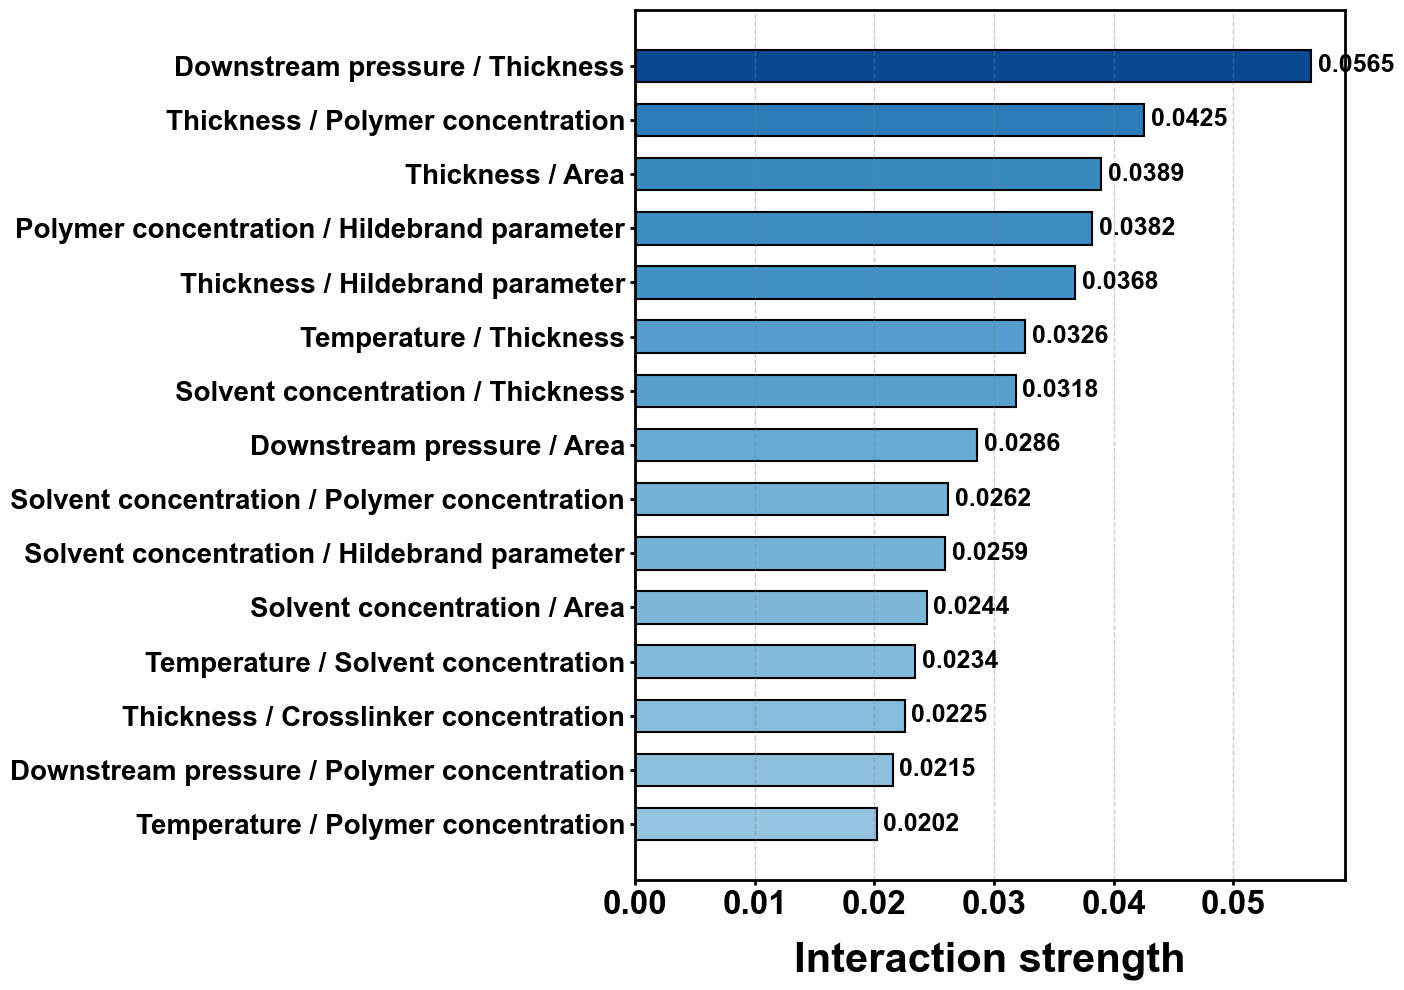

In [5]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.colors as mcolors

# ==========================================
# 9. SHAP Interaction Analysis (All Pairs)
# ==========================================
print("\n🚀 Starting SHAP Interaction Analysis for ALL feature pairs...")

# 1. Prepare Data
# ------------------------------------------
try:
    best_model_obj = final_pipeline.named_steps['model']
    preprocessor_obj = final_pipeline.named_steps['preprocessor']
except NameError:
    print("❌ Error: final_pipeline not defined.")
    exit()

# Get feature names
raw_feature_names = preprocessor_obj.get_feature_names_out()
feature_names_clean = [name.replace('num__', '').replace('cat__', '') for name in raw_feature_names]

# Sample data for speed
sample_size = min(500, len(X_train))
X_sample_raw = X_train.sample(n=sample_size, random_state=42)

# Transform data
X_sample_processed = preprocessor_obj.transform(X_sample_raw)
X_sample_df = pd.DataFrame(X_sample_processed, columns=feature_names_clean)

# 2. Calculate SHAP Interaction Values
# ------------------------------------------
print("Calculating SHAP interaction matrix (this may take time)...")
explainer = shap.TreeExplainer(best_model_obj)
shap_interaction_values = explainer.shap_interaction_values(X_sample_df)

# 3. Calculate Strength for ALL Pairs
# ------------------------------------------
interaction_data = []
n_features = len(feature_names_clean)

print(f"Calculating interaction strength for all {n_features} features...")

# Iterate through ALL unique pairs
for i in range(n_features):
    for j in range(i + 1, n_features):
        idx1 = i
        idx2 = j
        
        name1 = feature_names_clean[idx1]
        name2 = feature_names_clean[idx2]
        
        # Strength = mean absolute value of the off-diagonal element * 2
        strength = np.abs(shap_interaction_values[:, idx1, idx2]).mean() * 2
        
        interaction_data.append({
            'Feature 1': name1,
            'Feature 2': name2,
            'Pair': f"{name1} / {name2}",
            'Strength': strength
        })

# Convert to DataFrame and Sort
df_interaction = pd.DataFrame(interaction_data)
df_interaction = df_interaction.sort_values(by='Strength', ascending=True) 

# Output directory
output_dir = 'C:/Users/tinid/polymer/major revision/'
os.makedirs(output_dir, exist_ok=True)

# Save ALL interaction values to CSV
csv_path = os.path.join(output_dir, 'SHAP_Flux_All_Interaction_Values.csv')
df_interaction.to_csv(csv_path, index=False)
print(f"✅ All interaction values saved to: {csv_path}")

# Print Top 20 to console
print("\n--- Top 20 Strongest Interactions ---")
print(df_interaction.tail(20)[['Pair', 'Strength']].sort_values(by='Strength', ascending=False))

# ==========================================
# 4. Plotting (Top 15 Only)
# ==========================================
# We only plot the Top 15 to keep the chart readable
df_plot = df_interaction.tail(15).copy() 

# Global Style Settings
plt.style.use('default')
plt.rcParams.update({
    'font.family': ['Arial', 'DejaVu Sans', 'sans-serif'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 2.0,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'text.color': 'black',
    'xtick.major.width': 2.0,
    'ytick.major.width': 2.0,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
})

fig, ax = plt.subplots(figsize=(14, 10), facecolor='white')

# Dynamic Color Mapping
norm = mcolors.Normalize(vmin=df_plot['Strength'].min(), vmax=df_plot['Strength'].max())
colors = [plt.cm.Blues(0.4 + 0.5 * (val - df_plot['Strength'].min()) / (df_plot['Strength'].max() - df_plot['Strength'].min() + 1e-9)) for val in df_plot['Strength']]

# Bar Plot
bars = ax.barh(df_plot['Pair'], df_plot['Strength'], color=colors, edgecolor='black', linewidth=1.5, height=0.6)

# Labels and Titles
ax.set_xlabel("Interaction strength", fontsize=30, fontweight='bold', color='black', labelpad=15)
ax.set_ylabel("", fontsize=26, fontweight='bold', color='black')

plt.xticks(fontsize=24, fontweight='bold', color='black')
plt.yticks(fontsize=20, fontweight='bold', color='black') 

# Add value labels
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + (df_plot['Strength'].max() * 0.01)
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
            f'{width:.4f}', 
            ha='left', va='center', fontsize=18, fontweight='bold', color='black')

# Spines
for spine in ax.spines.values():
    spine.set_linewidth(2.0)
    spine.set_color('black')

# Grid
ax.grid(axis='x', linestyle='--', alpha=0.4, color='gray', linewidth=1)

plt.tight_layout()

# Save Plot
save_name = os.path.join(output_dir, 'SHAP_Flux_Interaction_Strength_Top15.png')
plt.savefig(save_name, dpi=300, bbox_inches='tight')
print(f"✅ Top 15 Interaction Plot saved to: {save_name}")

plt.show()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.inspection import partial_dependence
import matplotlib.colors as mcolors
import os
import itertools

# ==========================================
# 11. 批量绘制 36 个 2D PDP (Top 9 特征全排列)
# ==========================================
print("\n🚀 正在准备绘制 Top 36 特征对的 2D PDP 图...")

# 1. 准备环境与数据
# ------------------------------------------
# 提取模型和预处理器
try:
    best_model_obj = final_pipeline.named_steps['model']
    preprocessor_obj = final_pipeline.named_steps['preprocessor']
except NameError:
    print("❌ 错误: final_pipeline 未定义。")
    exit()

# 加载原始数据 (用于还原坐标轴)
raw_file_path = 'C:/Users/tinid/polymer/major revision/通量MICE填补12.18.csv'
try:
    raw_data_full = pd.read_csv(raw_file_path)
    # 修复常见列名不一致
    if 'Hildebrand-parameters' in raw_data_full.columns:
        raw_data_full.rename(columns={'Hildebrand-parameters': 'Hildebrand parameters'}, inplace=True)
    if 'Hildebrand parameter' not in raw_data_full.columns and 'Hildebrand parameters' in raw_data_full.columns:
         raw_data_full.rename(columns={'Hildebrand parameters': 'Hildebrand parameter'}, inplace=True)
    print("✅ 原始数据加载成功，用于坐标轴还原。")
except:
    print("❌ 无法加载原始数据，将显示标准化数值。")
    raw_data_full = pd.DataFrame()

# 准备训练数据 (Processed)
raw_feature_names = preprocessor_obj.get_feature_names_out()
feature_names_clean = [name.replace('num__', '').replace('cat__', '') for name in raw_feature_names]
X_train_processed = preprocessor_obj.transform(X_train)
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names_clean)

# 2. 筛选 Top 9 特征
# ------------------------------------------
# 获取特征重要性
importance = best_model_obj.feature_importances_
feat_importance_pair = [(col, imp) for col, imp in zip(feature_names_clean, importance)]
# 排序并取前 9 个
feat_importance_pair.sort(key=lambda x: x[1], reverse=True)
top_9_features = [x[0] for x in feat_importance_pair[:9]]

print(f"🎯 选定的 Top 9 特征: {top_9_features}")

# 生成所有两两组合 (C(9,2) = 36)
interaction_pairs = list(itertools.combinations(top_9_features, 2))
print(f"📊 共生成 {len(interaction_pairs)} 个特征对，准备开始绘图...")

# 3. 全局样式设置 (High Contrast)
# ------------------------------------------
plt.style.use('default')
plt.rcParams.update({
    'font.family': ['Arial', 'DejaVu Sans', 'sans-serif'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 2.0,
    'xtick.color': 'black', 'ytick.color': 'black', 'text.color': 'black',
    'xtick.major.width': 2.0, 'ytick.major.width': 2.0,
    'xtick.labelsize': 30, 'ytick.labelsize': 30
})

# 定义高对比度红蓝 Colormap (仿图 C/D/E)
colors = ["#1a2a6c", "#4c72b0", "#ffffff", "#c44e52", "#800000"] 
cmap_custom = mcolors.LinearSegmentedColormap.from_list("HighContrastRedBlue", colors, N=256)

# 输出目录
output_dir = 'C:/Users/tinid/polymer/major revision/PDP_2D_Flux_Top36/'
os.makedirs(output_dir, exist_ok=True)

# 4. 循环绘制 36 张图
# ------------------------------------------
for i, (feat1, feat2) in enumerate(interaction_pairs):
    print(f"   [{i+1}/{len(interaction_pairs)}] 正在绘制: {feat1} vs {feat2} ...")
    
    try:
        # A. 计算 PDP (Standardized Grid)
        pdp_results = partial_dependence(
            best_model_obj, X_train_df, [feat1, feat2], 
            grid_resolution=50, kind='average'
        )
        Z = pdp_results['average'][0] 
        x_vals_std = pdp_results['values'][0]
        y_vals_std = pdp_results['values'][1]
        
        # B. 坐标轴还原逻辑
        def unscale_grid(feature_name, grid_std):
            # 优先从原始数据获取 Mean/Std 进行还原
            if not raw_data_full.empty and feature_name in raw_data_full.columns:
                raw_series = raw_data_full[feature_name]
                mu = raw_series.mean()
                sigma = raw_series.std()
                return grid_std * sigma + mu
            # 如果是 One-Hot 编码特征 (如 Permeation type)，则不需要还原，直接返回 0/1
            elif "Permeation" in feature_name: 
                return grid_std 
            else:
                # 尝试模糊匹配 (比如 'Hildebrand parameter' vs 'Hildebrand parameters')
                for col in raw_data_full.columns:
                    if feature_name in col or col in feature_name:
                         raw_series = raw_data_full[col]
                         mu = raw_series.mean()
                         sigma = raw_series.std()
                         return grid_std * sigma + mu
                return grid_std

        x_vals_raw = unscale_grid(feat1, x_vals_std)
        y_vals_raw = unscale_grid(feat2, y_vals_std)
        
        # C. 构建网格
        X_grid, Y_grid = np.meshgrid(x_vals_raw, y_vals_raw)
        
        # D. 绘图
        fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
        
        # 使用 contourf 增强色块感
        cntr = ax.contourf(
            X_grid, Y_grid, Z.T, 
            levels=20, 
            cmap=cmap_custom, 
            extend='both'
        )
        
        # E. 样式细节
        ax.set_xlabel(feat1, fontsize=40, fontweight='bold', labelpad=15)
        ax.set_ylabel(feat2, fontsize=40, fontweight='bold', labelpad=15)
        
        # Colorbar
        cbar = plt.colorbar(cntr, ax=ax, pad=0.05)
        cbar.set_label('Predication value', fontsize=34, fontweight='bold', labelpad=15)
        cbar.ax.tick_params(labelsize=32, width=2)
        cbar.outline.set_linewidth(2)
        cbar.solids.set_edgecolor("face")

        # 边框与刻度
        for spine in ax.spines.values():
            spine.set_linewidth(2.0)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')

        plt.tight_layout()
        
        # 保存
        safe_name = f"{i+1}_{feat1}_vs_{feat2}".replace(" ", "_").replace("/", "_").replace(":", "")
        save_path = os.path.join(output_dir, f'PDP_{safe_name}.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig) # 关闭图像释放内存，防止循环36次后崩溃
        
    except Exception as e:
        print(f"⚠️ 跳过 {feat1} vs {feat2}: {e}")

print(f"\n✅ 所有 36 张 2D PDP 图绘制完成！请查看文件夹: {output_dir}")


🚀 正在准备绘制 Top 36 特征对的 2D PDP 图...
✅ 原始数据加载成功，用于坐标轴还原。
🎯 选定的 Top 9 特征: ['Thickness', 'Polymer concentration', 'Temperature', 'Solvent concentration', 'Area', 'Downstream pressure', 'Hildebrand parameter', 'Crosslinker concentration', 'Monomer molecular weight']
📊 共生成 36 个特征对，准备开始绘图...
   [1/36] 正在绘制: Thickness vs Polymer concentration ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [2/36] 正在绘制: Thickness vs Temperature ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [3/36] 正在绘制: Thickness vs Solvent concentration ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [4/36] 正在绘制: Thickness vs Area ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [5/36] 正在绘制: Thickness vs Downstream pressure ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [6/36] 正在绘制: Thickness vs Hildebrand parameter ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [7/36] 正在绘制: Thickness vs Crosslinker concentration ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [8/36] 正在绘制: Thickness vs Monomer molecular weight ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [9/36] 正在绘制: Polymer concentration vs Temperature ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [10/36] 正在绘制: Polymer concentration vs Solvent concentration ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [11/36] 正在绘制: Polymer concentration vs Area ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [12/36] 正在绘制: Polymer concentration vs Downstream pressure ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [13/36] 正在绘制: Polymer concentration vs Hildebrand parameter ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [14/36] 正在绘制: Polymer concentration vs Crosslinker concentration ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [15/36] 正在绘制: Polymer concentration vs Monomer molecular weight ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [16/36] 正在绘制: Temperature vs Solvent concentration ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [17/36] 正在绘制: Temperature vs Area ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [18/36] 正在绘制: Temperature vs Downstream pressure ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [19/36] 正在绘制: Temperature vs Hildebrand parameter ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [20/36] 正在绘制: Temperature vs Crosslinker concentration ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [21/36] 正在绘制: Temperature vs Monomer molecular weight ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [22/36] 正在绘制: Solvent concentration vs Area ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [23/36] 正在绘制: Solvent concentration vs Downstream pressure ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [24/36] 正在绘制: Solvent concentration vs Hildebrand parameter ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [25/36] 正在绘制: Solvent concentration vs Crosslinker concentration ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [26/36] 正在绘制: Solvent concentration vs Monomer molecular weight ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [27/36] 正在绘制: Area vs Downstream pressure ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [28/36] 正在绘制: Area vs Hildebrand parameter ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [29/36] 正在绘制: Area vs Crosslinker concentration ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [30/36] 正在绘制: Area vs Monomer molecular weight ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [31/36] 正在绘制: Downstream pressure vs Hildebrand parameter ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [32/36] 正在绘制: Downstream pressure vs Crosslinker concentration ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [33/36] 正在绘制: Downstream pressure vs Monomer molecular weight ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [34/36] 正在绘制: Hildebrand parameter vs Crosslinker concentration ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [35/36] 正在绘制: Hildebrand parameter vs Monomer molecular weight ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


   [36/36] 正在绘制: Crosslinker concentration vs Monomer molecular weight ...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(



✅ 所有 36 张 2D PDP 图绘制完成！请查看文件夹: C:/Users/tinid/polymer/major revision/PDP_2D_Flux_Top36/
